In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Load the Dataset**

In [ ]:
# Load the excel file
df = pd.read_excel("/content/drive/MyDrive/Master's degree/ML-DataScience/Real_estate_valuation_data_set.xlsx")

In [ ]:
# Display the data
df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.666667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250000,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000000,8.1,104.81010,5,24.96674,121.54067,52.5


# **Data Exploration**

In [ ]:
# Check for the type of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


We can see that there are no missing values in the data, and the type of all columns is numeric.

In [ ]:
# Basic statistics of the numerical columns
df.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


We observe that the mean of the target variable, which represents the house price of the unit area (Y column), is approximately 38. However, the maximum value in the dataset is 117. This suggests that there might be the presence of outliers that may potentially impact the performance of our regression models. To address this, we need to conduct further analysis to identify and handle these outliers appropriately.

#**Data Visualization**

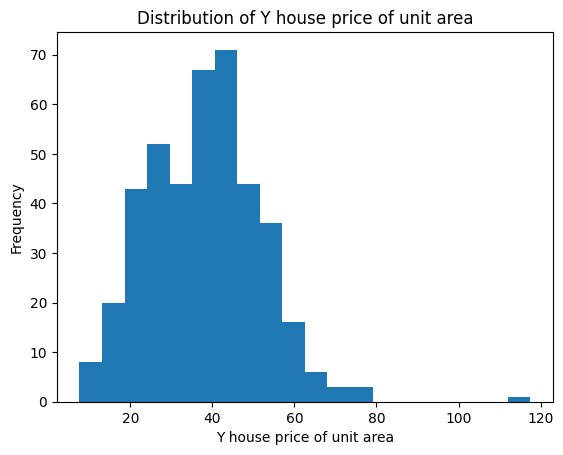

In [ ]:
# Plot the distribution of the y label.
plt.hist(df['Y house price of unit area'], bins=20)
plt.xlabel('Y house price of unit area')
plt.ylabel('Frequency')
plt.title('Distribution of Y house price of unit area')
plt.show()

The distribution of the target variable appears to be right skewed. However, upon closer inspection, we observe the presence of outliers beyond the expected range of values.

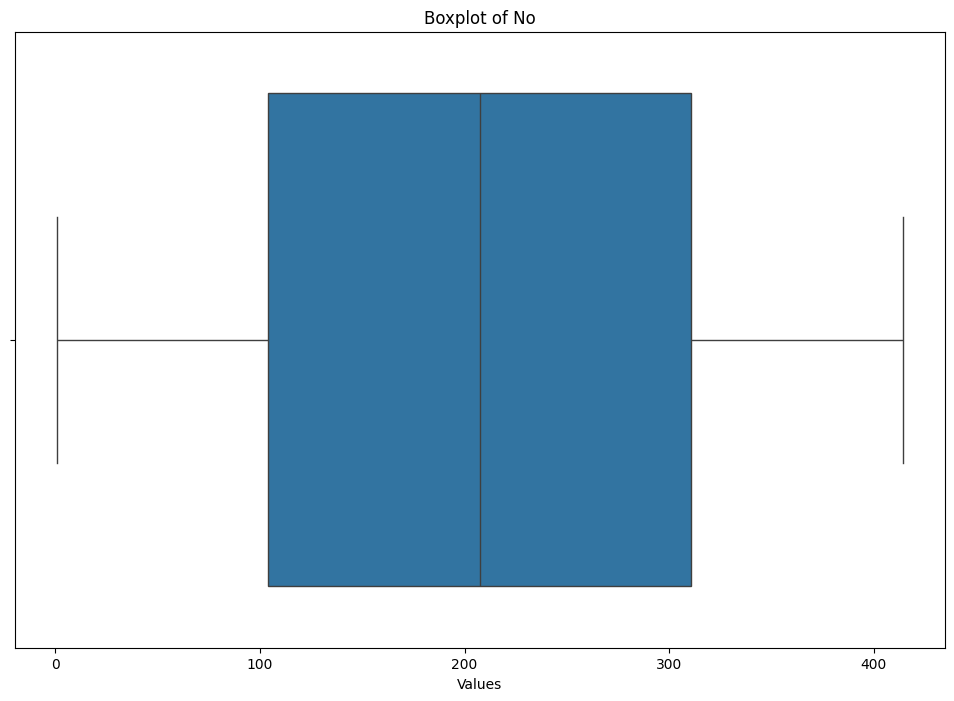

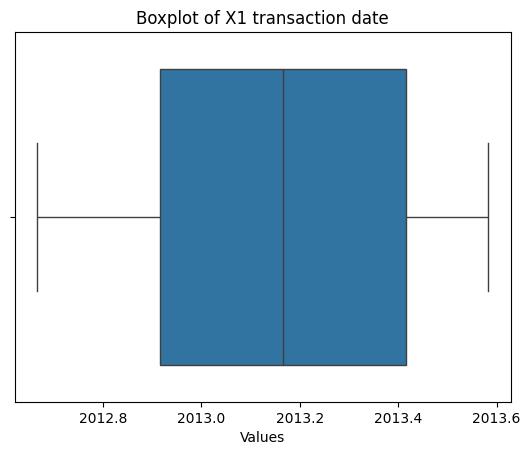

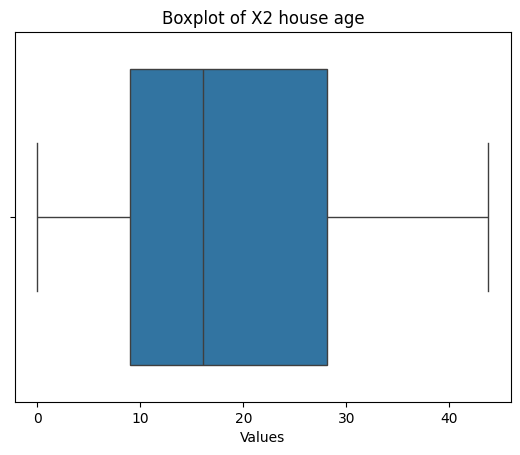

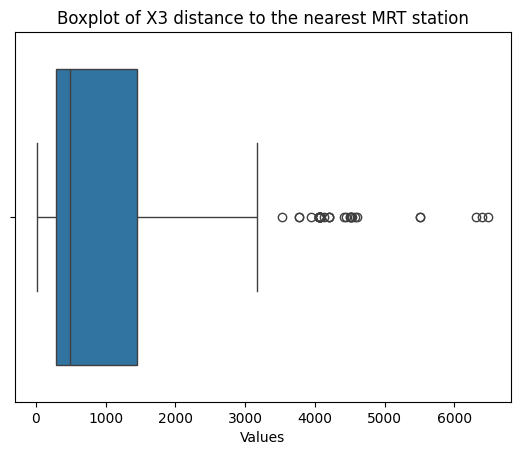

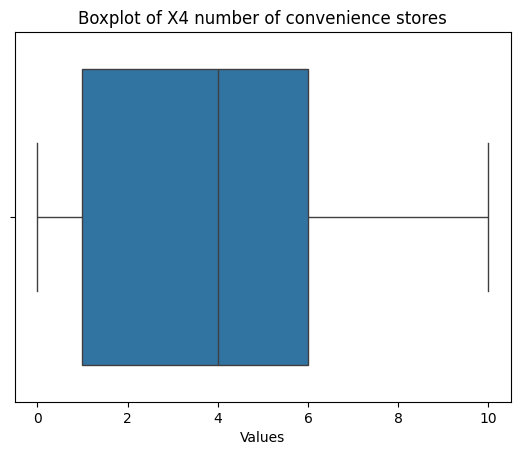

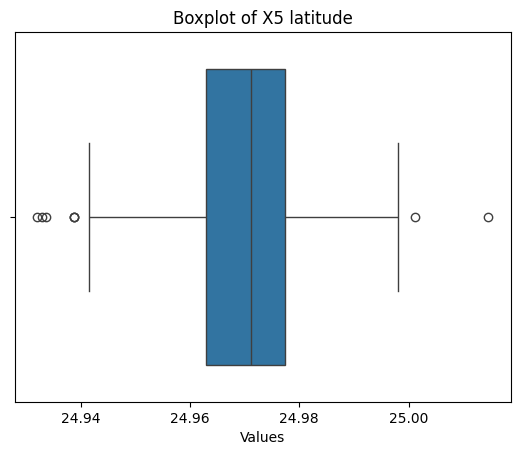

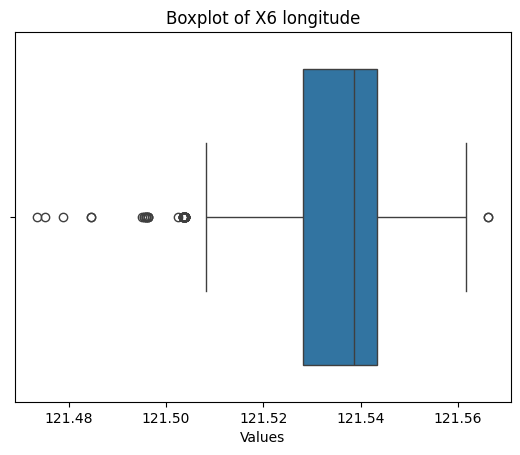

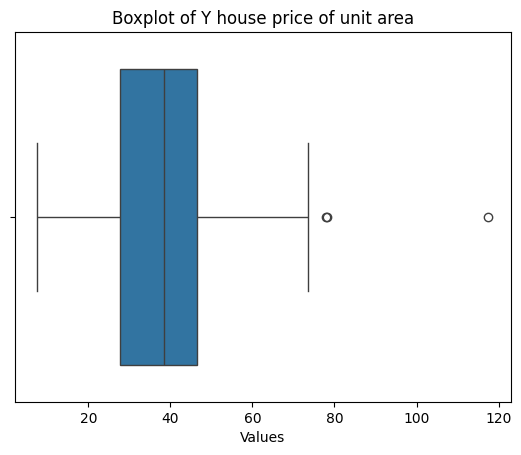

In [ ]:
# Plotting boxplot of each feature in the df in order to view outliers
plt.figure(figsize=(12, 8))

# Iterate over each feature in the DataFrame
for column in df.columns:
    # Create a boxplot for the current feature
    sns.boxplot(x=df[column])

    # Set plot title and labels
    plt.title(f'Boxplot of {column}')
    plt.xlabel('Values')

    # Display the plot
    plt.show()


According to the boxplots, we can see that some features in the data have outliers and therefore we need to handle them in the feature engineering part.

In [ ]:
# Finding the outliers in the data according to z-score
from scipy.stats import zscore

# Define a DataFrame to store the z-scores for each feature
z_scores_df = pd.DataFrame(index=df.index, columns=df.columns)

# Iterate over each column (feature) in the DataFrame
for column in df.columns:
    # Calculate z-scores for the current feature
    z_scores = zscore(df[column])

    # Store the z-scores in the z_scores_df DataFrame
    z_scores_df[column] = z_scores

# Set the threshold for identifying outliers (e.g., z-score greater than 3 or less than -3)
threshold = 3

# Create a mask to identify outliers
outliers_mask = (z_scores_df > threshold) | (z_scores_df < -threshold)


# **Visualizations of features vs y_target**

Text(0.5, 1.0, 'House Price vs Number of Convenience Stores')

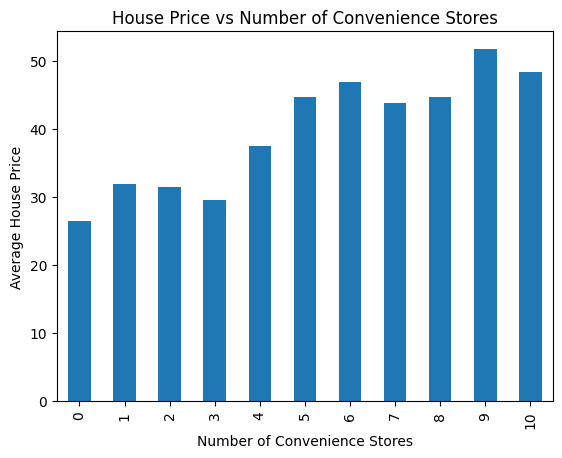

In [ ]:
# plot of House Price vs Number of Convenience Stores

df.groupby('X4 number of convenience stores')['Y house price of unit area'].mean().plot(kind='bar')
plt.xlabel('Number of Convenience Stores')
plt.ylabel('Average House Price')
plt.title("House Price vs Number of Convenience Stores")

Based on the barplot, it appears that the average house price is positively correlated with the number of convenience stores. Specifically, as the number of convenience stores increases, the average price of houses tends to rise. This suggests a potential relationship between the availability of nearby convenience stores and the housing market value.




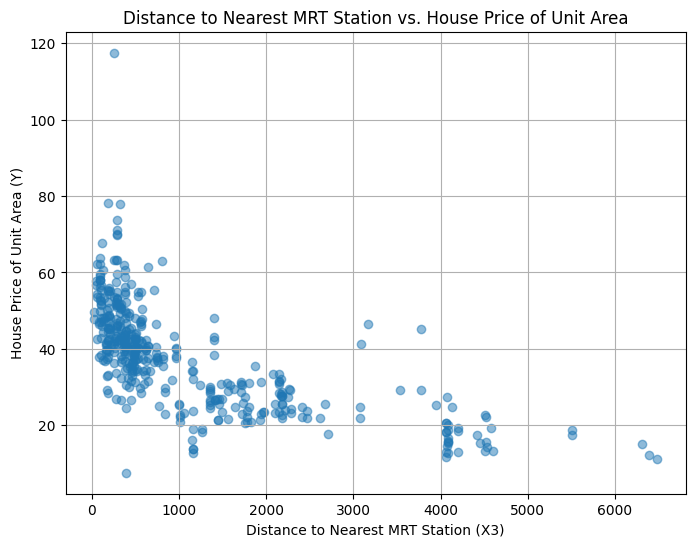

In [ ]:
# Plot of correlation between the distance to the nearest MRT station and the house price of unit area

plt.figure(figsize=(8, 6))
plt.scatter(df['X3 distance to the nearest MRT station'], df['Y house price of unit area'], alpha=0.5)
plt.title('Distance to Nearest MRT Station vs. House Price of Unit Area')
plt.xlabel('Distance to Nearest MRT Station (X3)')
plt.ylabel('House Price of Unit Area (Y)')
plt.grid(True)
plt.show()

Based on this scatterplot, we can infer that the smallest the distance to the nearset MRT station, the higher the house price of unit area.

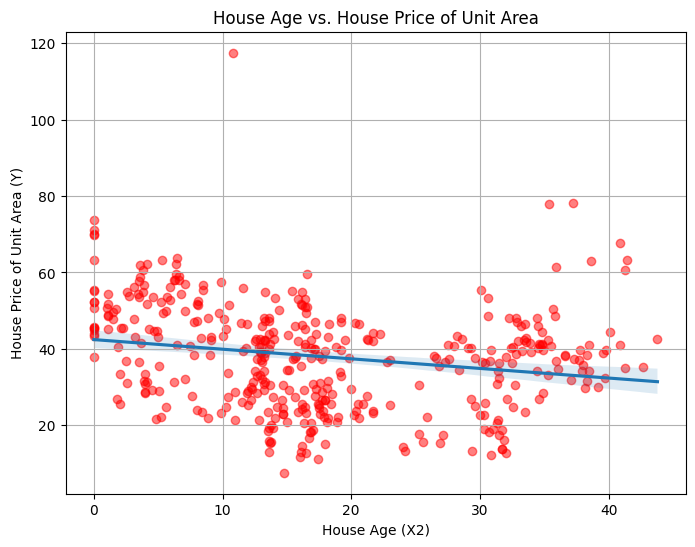

In [ ]:
# Plot of correlation between X2 house age and Y house price of unit area
plt.figure(figsize=(8, 6))
sns.regplot(x=df['X2 house age'], y=df['Y house price of unit area'], scatter_kws={'color': 'red', 'alpha': 0.5})
plt.title('House Age vs. House Price of Unit Area')
plt.xlabel('House Age (X2)')
plt.ylabel('House Price of Unit Area (Y)')
plt.grid(True)
plt.show()

While there appears to be a discernible trend suggesting that younger houses tend to command higher prices, the correlation between house age and house price of unit area is not distinctly strong.

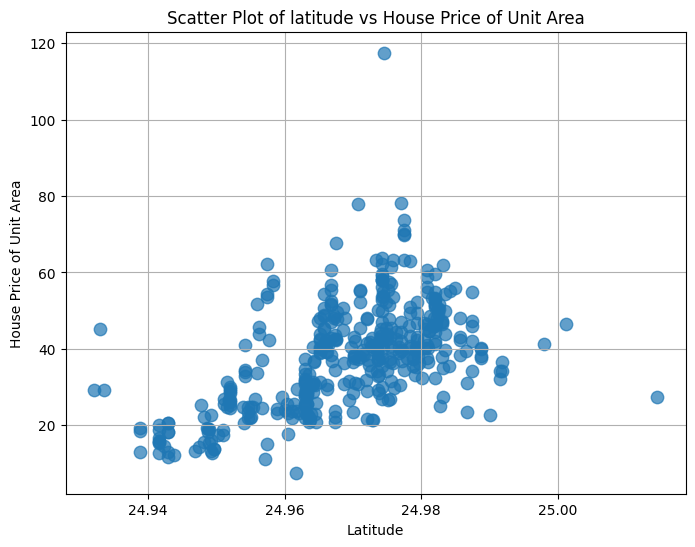

In [ ]:
# Plot of correlation between X5 latitude and Y house price of unit area
plt.figure(figsize=(8, 6))
plt.scatter(df['X5 latitude'], df['Y house price of unit area'], s=80, alpha=0.7)
plt.xlabel('Latitude')
plt.ylabel('House Price of Unit Area')
plt.title('Scatter Plot of latitude vs House Price of Unit Area')
plt.grid(True)
plt.show()

It seems that there is a positive correlation between the latitude feature to the house price of unit area.

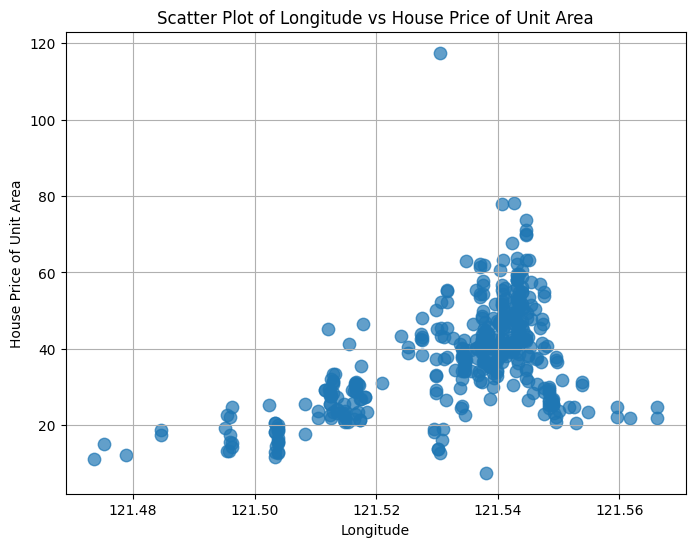

In [ ]:
# Plot of correlation between X6 longitude and Y house price of unit area
plt.figure(figsize=(8, 6))
plt.scatter(df['X6 longitude'], df['Y house price of unit area'], s=80, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('House Price of Unit Area')
plt.title('Scatter Plot of Longitude vs House Price of Unit Area')
plt.grid(True)
plt.show()

It seems that there is a positive correlation between the longitude feature to the house price of unit area.

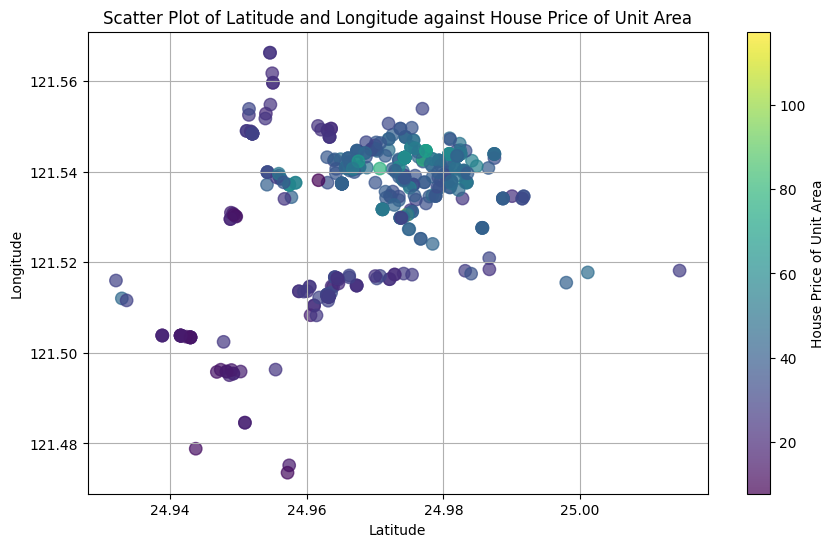

In [ ]:
# Plot of correlation between X5 latitude, X6 longitude and Y house price of unit area
plt.figure(figsize=(10, 6))
plt.scatter(df['X5 latitude'], df['X6 longitude'], s=80, c=df['Y house price of unit area'], cmap='viridis', alpha=0.7)
plt.colorbar(label='House Price of Unit Area')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Scatter Plot of Latitude and Longitude against House Price of Unit Area')
plt.grid(True)
plt.show()

The graph effectively demonstrates the relationship between house prices and geographical location. Brighter points, indicating higher prices, are clustered in central areas, while dimmer points, suggesting lower prices, are scattered across remote regions.

<Axes: >

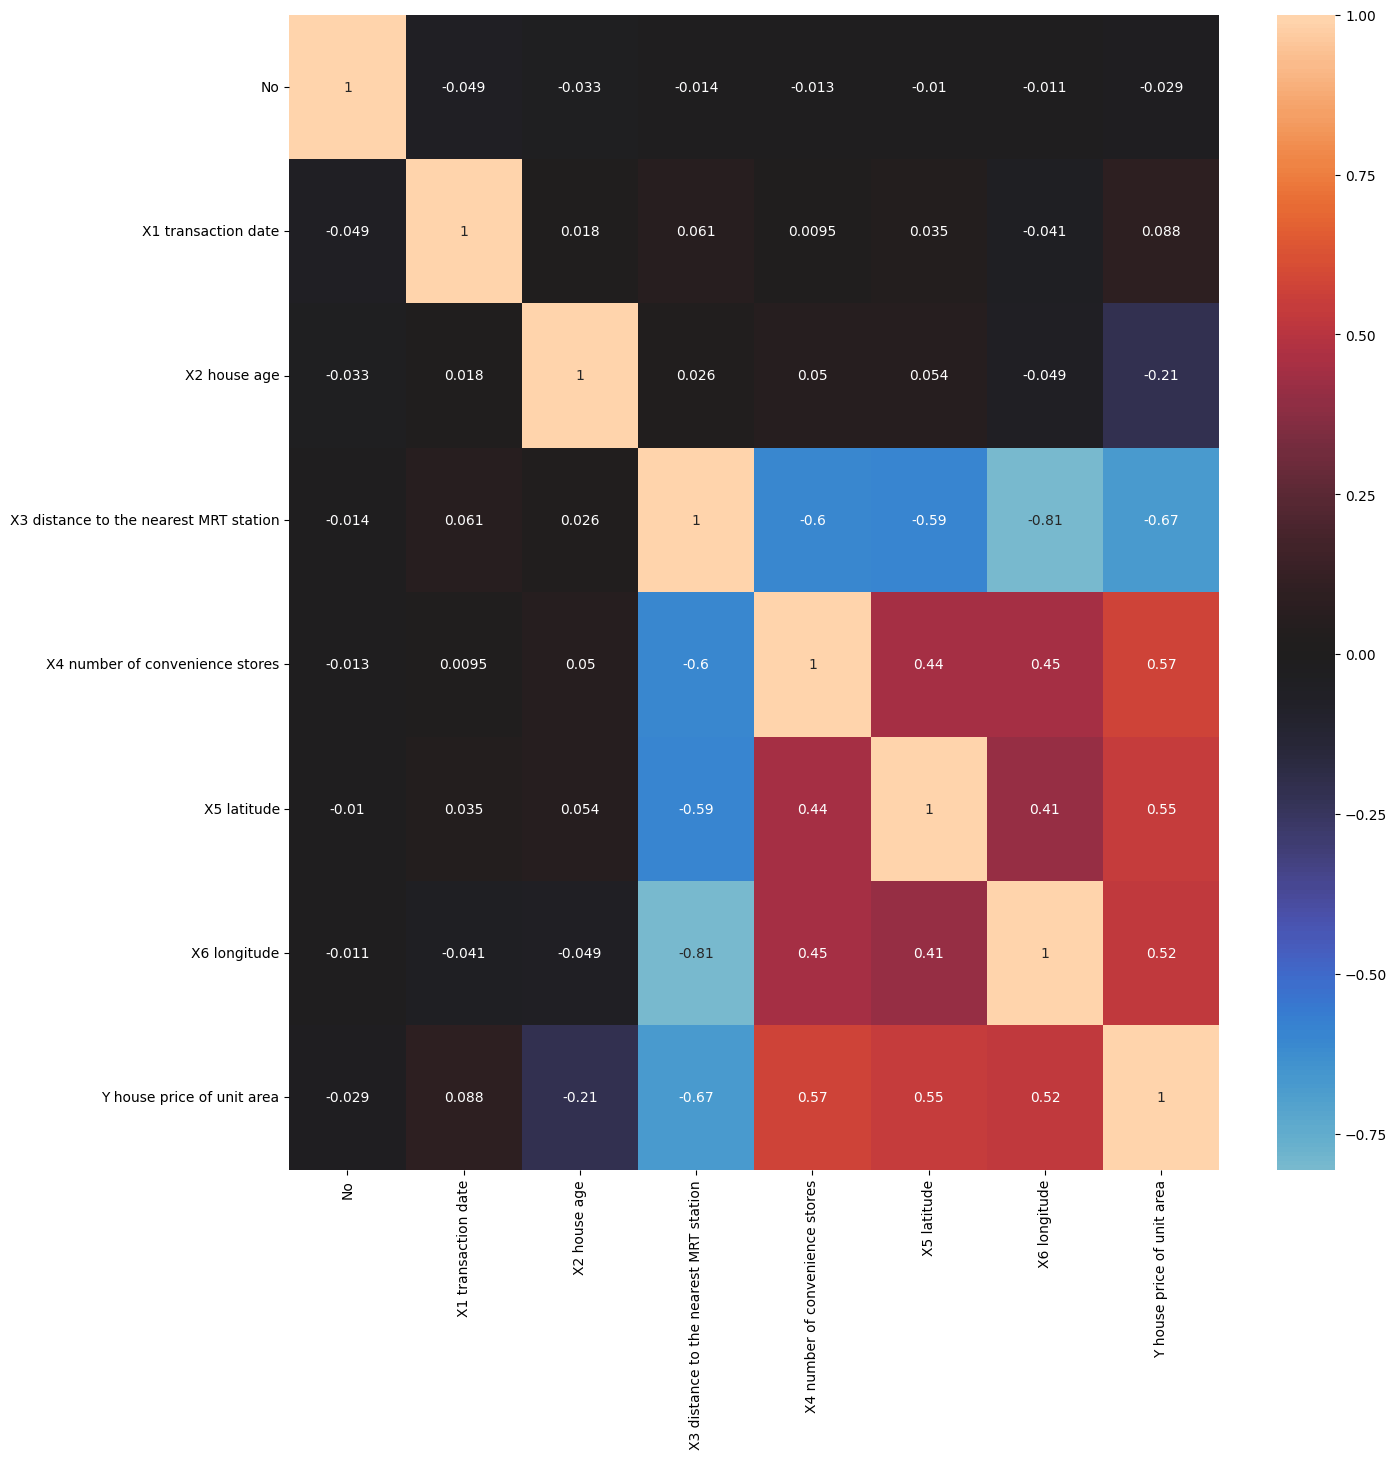

In [ ]:
# A Heatmap visualization to undertand the connections in the data better
corr = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), center=0, annot=True)

Upon examining the heatmap, it becomes apparent that several features exhibit a notable correlation with the target variable (Y house price of unit area). Specifically, distance to the nearest MRT station, the number of convenience stores, latitude, and longitude stand out. Notably, distance to the nearest MRT station demonstrates a negative correlation, implying that as this distance increases, the price of the house tends to decrease. This observation underscores the importance of these features in influencing the pricing dynamics of the houses.


# **Preprocessing and Feature Extraction**

In [ ]:
# Normalization of the y Target Variable
from scipy.stats import boxcox

# Apply a logarithmic transformation to 'y'
df['Y house price of unit area'], best_lambda = boxcox(df['Y house price of unit area'])

We've opted for a logarithmic transformation to enhance the normality of the y variable. This transformation involves applying the logarithmic function to the y variable, which can help in achieving a more symmetric distribution.

In [ ]:
# Print the number of outliers
outliers_mask.sum()

No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    5
X4 number of convenience stores           0
X5 latitude                               1
X6 longitude                              5
Y house price of unit area                1
dtype: int64

After identifying a few outliers in our dataset, we made the decision to remove these outliers from the data. Given that some rows may contain more than one outlier, we opted to remove only a few of these rows. This approach ensures that we maintain the integrity of the dataset while mitigating the impact of outliers on our analysis.

In [ ]:
# Filter out rows containing outliers
df = df[~outliers_mask.any(axis=1)]

In [ ]:
# Checking for the data shape after removing outliers
df.shape

(407, 8)

We removed 6 rows with outliers from the data.

In [ ]:
# Display of the basic statistics of the data afer removing the outliers
df.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000
mean,207.906634,2013.146192,17.638329,1017.646541,4.149877,24.969113,121.534069,12.589391
std,119.606544,0.281519,11.423157,1134.448058,2.939395,0.012150,0.014223,2.956898
min,1.000000,2012.666667,0.000000,23.382840,0.000000,24.932070,121.495070,3.910484
25%,104.500000,2012.916667,8.900000,289.324800,1.000000,24.963050,121.529810,10.498113
50%,207.000000,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538850,12.960331
75%,311.500000,2013.416667,27.800000,1414.837000,6.000000,24.977705,121.543480,14.631369
max,414.000000,2013.583333,43.800000,4605.749000,10.000000,25.001150,121.566270,20.473534


After the removal of outliers, the statistical properties of the dataset have undergone noticeable changes, indicating a better alignment with the underlying data distribution. This adjustment enhances the suitability of the dataset for subsequent analysis and regression models.

# **Data Visualization After Preprocessing**

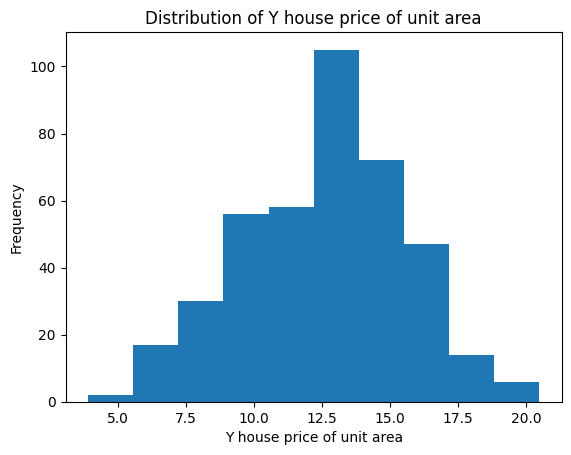

In [ ]:
# Plot the distribution of the y label after transformation.
plt.hist(df['Y house price of unit area'], bins=10)
plt.xlabel('Y house price of unit area')
plt.ylabel('Frequency')
plt.title('Distribution of Y house price of unit area')
plt.show()

The distribution of the target variable 'y' visualized after applying transformation. The resulting distribution suggests that the 'y' label now
follows a more normal distribution pattern.

<Axes: >

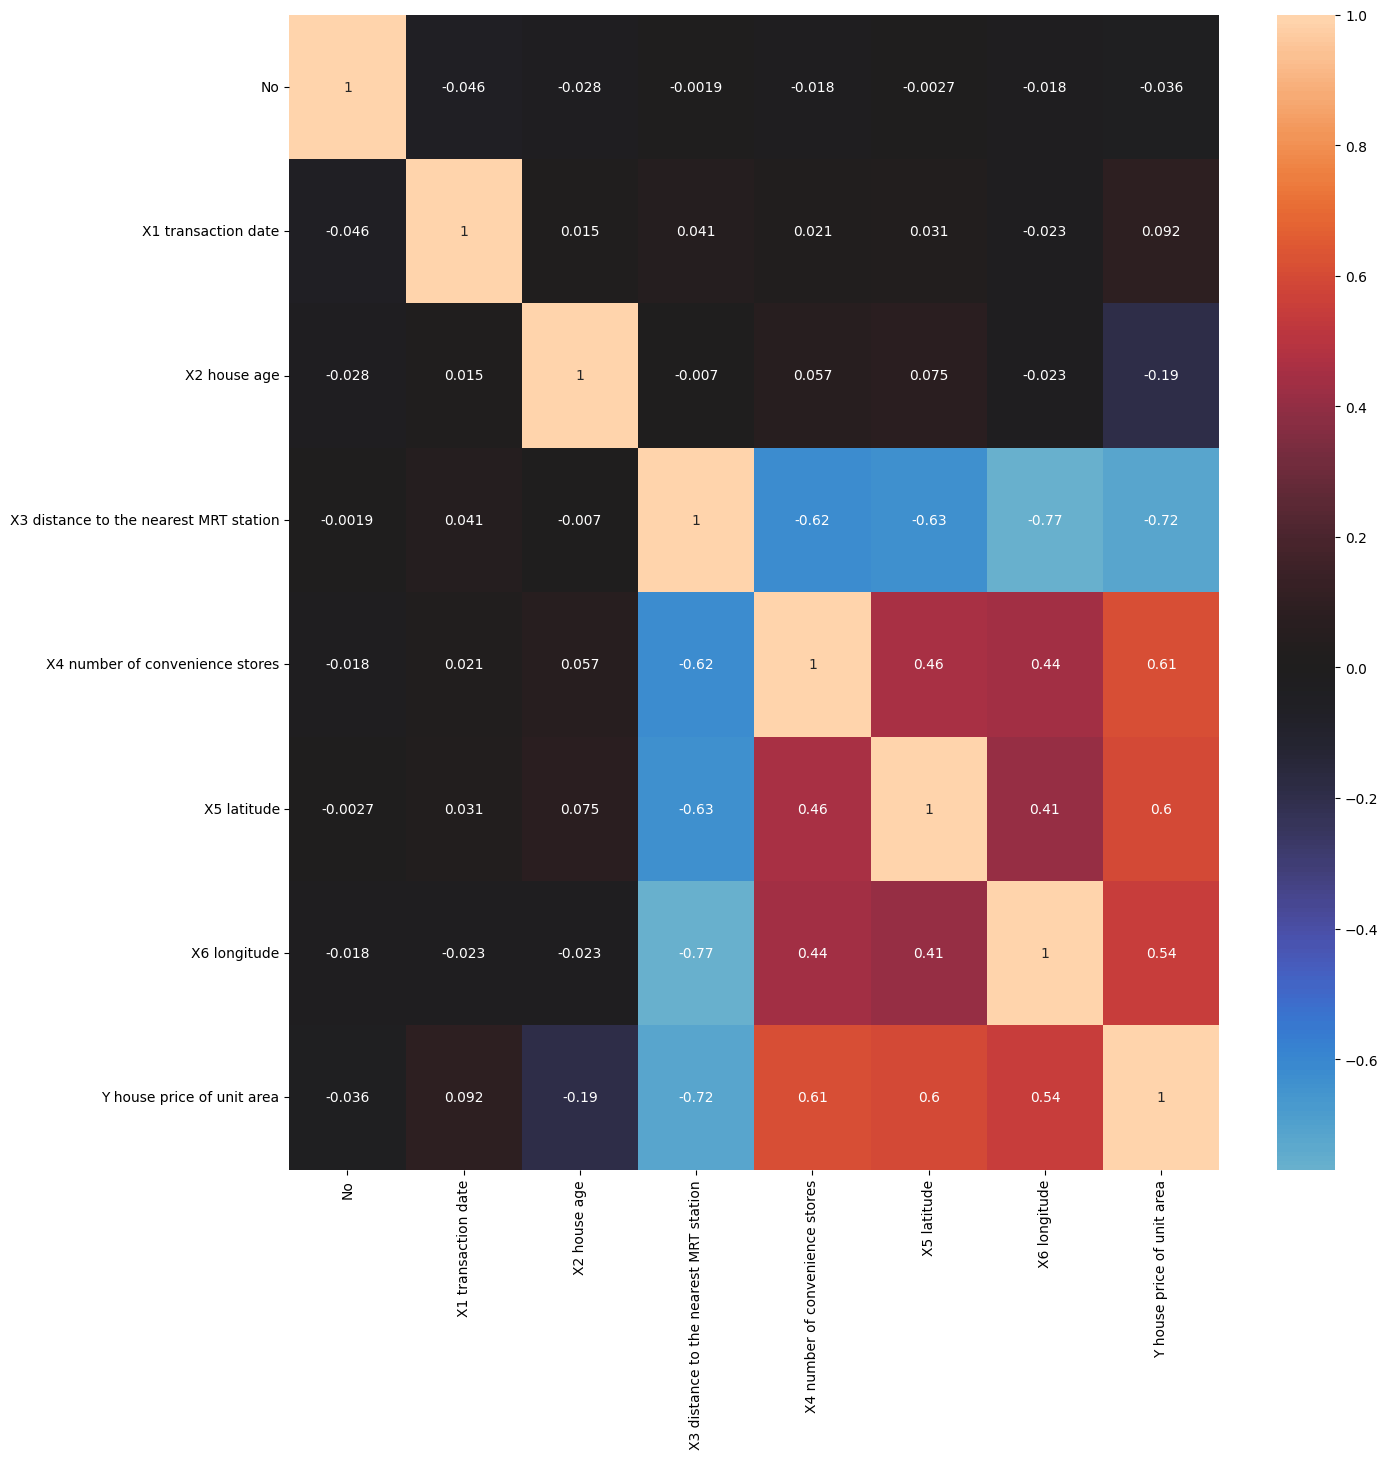

In [ ]:
# Heatmap visualization after preprocessing
corr = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), center=0, annot=True)

The correlations in the data remained largely unchanged even after applying a transformation to the y_target.

# **Feature Selection**

In [ ]:
# Define of x features and y target
x = df[['X2 house age',	'X3 distance to the nearest MRT station',	'X4 number of convenience stores', 'X5 latitude',	'X6 longitude']]
y = df['Y house price of unit area']
print('x:\n',x)
print('y:\n',y)

x:
      X2 house age  X3 distance to the nearest MRT station  \
0            32.0                                84.87882   
1            19.5                               306.59470   
2            13.3                               561.98450   
3            13.3                               561.98450   
4             5.0                               390.56840   
..            ...                                     ...   
409          13.7                              4082.01500   
410           5.6                                90.45606   
411          18.8                               390.96960   
412           8.1                               104.81010   
413           6.5                                90.45606   

     X4 number of convenience stores  X5 latitude  X6 longitude  
0                                 10     24.98298     121.54024  
1                                  9     24.98034     121.53951  
2                                  5     24.98746     121.54391  

We excluded the No and X1 transaction date columns as they lacked meaningful numerical information based on the heatmap.

# **Models**

In [ ]:
# Creating a dataframe to compare scores of the models
scores = pd.DataFrame(columns=['train MSE','validation MSE', 'train MAE','validation MAE', 'train R^2','validation R^2'],index=['linear_opt', 'xgb_opt', 'forest_opt', 'tree_opt', 'knn_opt'])
scores

,train MSE,validation MSE,train MAE,validation MAE,train R^2,validation R^2
linear_opt,NaN,NaN,NaN,NaN,NaN,NaN
xgb_opt,NaN,NaN,NaN,NaN,NaN,NaN
forest_opt,NaN,NaN,NaN,NaN,NaN,NaN
tree_opt,NaN,NaN,NaN,NaN,NaN,NaN
knn_opt,NaN,NaN,NaN,NaN,NaN,NaN


Now we shall compare the results of each model to decide which one predicts the Y value that is the most accurately.

In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state=42)


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(284, 5)
(284,)
(62, 5)
(62,)
(61, 5)
(61,)


### **Linear Regression Model**

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
linear = LinearRegression()

# Fit the model on the training data
linear.fit(x_train, y_train)

# Predict the target variable on the training, testing, and validation data
y_pred_train = linear.predict(x_train)
y_pred_val = linear.predict(x_val)

# Calculate Mean Squared Error (MSE) for training, testing, and validation data
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)

# Calculate Mean Absolute Error (MAE) for training, testing, and validation data
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_val = mean_absolute_error(y_val, y_pred_val)

# Calculate r squared for training, testing, and validation data
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)

# Printing the evaluation metrics for training data
print("Mean Squared Error (Train):", mse_train)
print("Mean Absolute Error (Train):", mae_train)
print("R-squared (Train):", r2_train)

# Printing the evaluation metrics for validation data
print("Mean Squared Error (Validation):", mse_val)
print("Mean Absolute Error (Validation):", mae_val)
print("R-squared (Validation):", r2_val)

# Update scores dataframe with train and validation metrics for the Linear Regression model
scores.at['linear_opt', 'train MSE'] = mean_squared_error(y_train, y_pred_train)
scores.at['linear_opt', 'train MAE'] = mean_absolute_error(y_train, y_pred_train)
scores.at['linear_opt', 'train R^2'] = r2_score(y_train, y_pred_train)
scores.at['linear_opt', 'validation MSE'] = mean_squared_error(y_val, y_pred_val)
scores.at['linear_opt', 'validation MAE'] = mean_absolute_error(y_val, y_pred_val)
scores.at['linear_opt', 'validation R^2'] = r2_score(y_val, y_pred_val)

Mean Squared Error (Train): 3.204770892606773
Mean Absolute Error (Train): 1.3085631768953407
R-squared (Train): 0.6323283693272974
Mean Squared Error (Validation): 2.8930464635786857
Mean Absolute Error (Validation): 1.1727744694451825
R-squared (Validation): 0.6497768978578238


The higher validation MSE compared to train suggests the model may be overfitting slightly to the training data.
Validation errors (MAE) not too far off from train, indicating reasonable generalization.

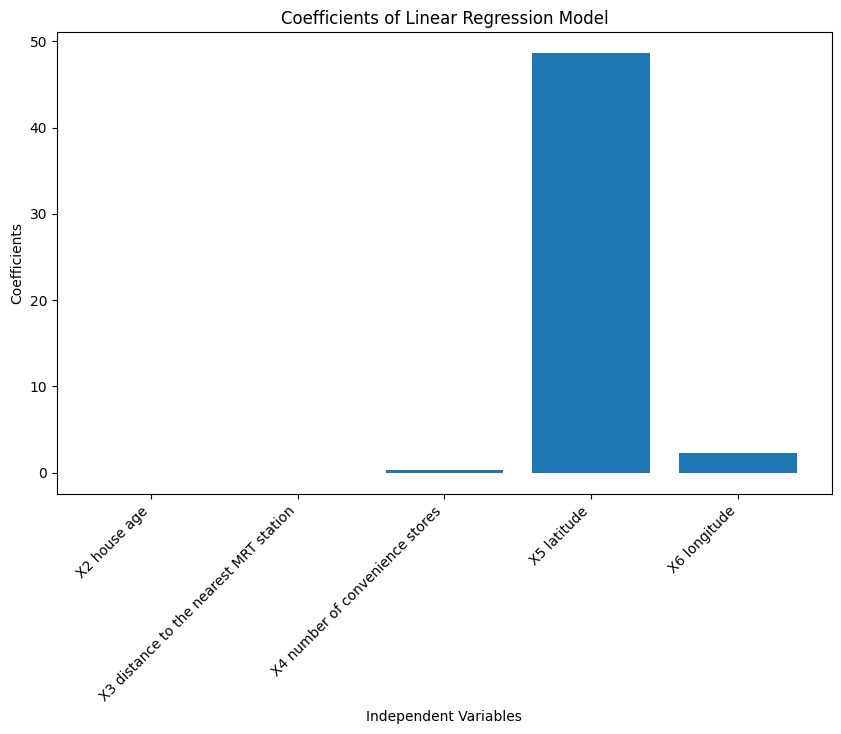

In [ ]:
# Visualization of the coefficients
# Coefficients of the linear regression model
coefficients = linear.coef_

# Names of the independent variables
feature_names = x.columns

# Plotting the coefficients
plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefficients)
plt.xlabel('Independent Variables')
plt.ylabel('Coefficients')
plt.title('Coefficients of Linear Regression Model')
plt.xticks(rotation=45, ha='right')
plt.show()

Based on the Linear Regression Model the most important feature is "X5 latitude".

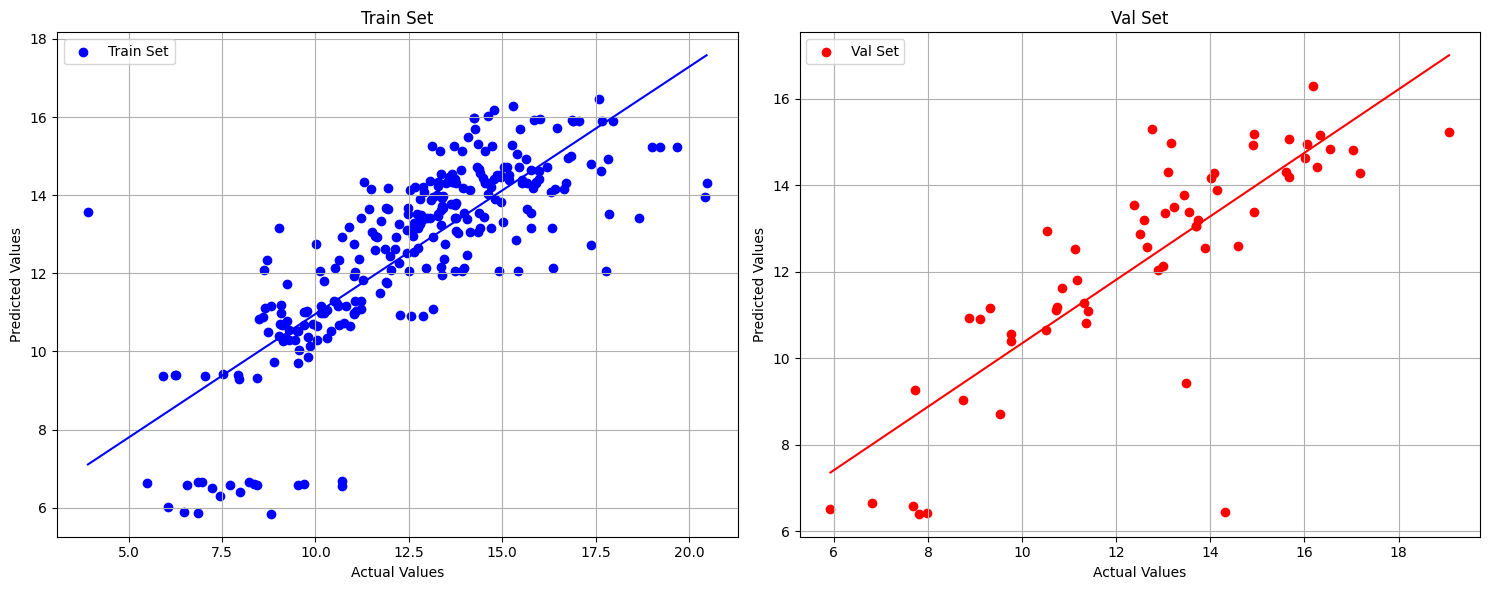

In [ ]:
# Visualize of train and test sets vs predicted values

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for train set
axs[0].scatter(y_train, y_pred_train, color='blue', label='Train Set')
# Plot the linear regression line for train set
axs[0].plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, y_pred_train, 1))(np.unique(y_train)), color='blue')
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Train Set')
axs[0].legend()
axs[0].grid(True)

# Scatter plot for val set
axs[1].scatter(y_val, y_pred_val, color='red', label='Val Set')
# Plot the linear regression line for val set
axs[1].plot(np.unique(y_val), np.poly1d(np.polyfit(y_val, y_pred_val, 1))(np.unique(y_val)), color='red')
axs[1].set_xlabel('Actual Values')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Val Set')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Overall, these plots indicate some degree of overfitting, where the model is capturing the training data patterns very well, but struggling somewhat to generalize those patterns accurately to the unseen validation data. The validation set shows a more linear, narrower prediction trend compared to the more scattered training set predictions.

### **XGB model**

In [ ]:
from xgboost import XGBRegressor

# Initializing XGBoost regressor
XGB = XGBRegressor()

# Fitting the model on the training data
XGB.fit(x_train, y_train)

# Predicting the target variable for training data
y_pred_train = XGB.predict(x_train)

# Predicting the target variable for validation data
y_pred_val = XGB.predict(x_val)

# Calculating the evaluation metrics for training data
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Calculating the evaluation metrics for validation data
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Printing the evaluation metrics for training data
print("Mean Squared Error (Train):", mse_train)
print("Mean Absolute Error (Train):", mae_train)
print("R-squared (Train):", r2_train)

# Printing the evaluation metrics for validation data
print("Mean Squared Error (Validation):", mse_val)
print("Mean Absolute Error (Validation):", mae_val)
print("R-squared (Validation):", r2_val)

Mean Squared Error (Train): 0.09217710007943215
Mean Absolute Error (Train): 0.11649298180205613
R-squared (Train): 0.9894248588018975
Mean Squared Error (Validation): 1.9452559969935983
Mean Absolute Error (Validation): 0.9948511569649134
R-squared (Validation): 0.7645134295959293


These metrics suggest that while the model fits the training data very well, its performance on the validation set is noticeably worse, indicating potential overfitting issues. Further steps like using grid search needed in order to improve generalization.

### **Grid Search**

In [ ]:
from xgboost import XGBRegressor

# Initialize variables to store the best parameters and evaluation metrics
best_params = None
best_mse = None
best_mae = None
best_r2 = None

# Iterate over different values of max_depth and n_estimators
for max_depth in tqdm(range(2, 15)):
    for num_est in [200, 500, 1000, 1500]:
      # Define the parameters for the XGBoost model
        params = {'max_depth': max_depth, 'n_estimators': num_est}

        # Initialize XGBoost regressor with the specified parameters
        xgb = XGBRegressor(**params)

        # Fit the XGBoost model on the training data
        xgb.fit(x_train, y_train)

        # Make predictions on the training and validation data
        y_pred_val = xgb.predict(x_val)
        val_mse = mean_squared_error(y_val, y_pred_val)
        val_mae = mean_absolute_error(y_val, y_pred_val)
        val_r2 = r2_score(y_val, y_pred_val)
        if (best_mse is None or val_mse < best_mse) and (best_mae is None or val_mae < best_mae) and (best_r2 is None or val_r2 > best_r2):
            best_params = params
            best_mse = val_mse
            best_mae = val_mae
            best_r2 = val_r2

print(f'Best validation MSE: {best_mse}')
print(f'Best validation MAE: {best_mae}')
print(f'Best validation R^2: {best_r2}')
print(f'Best parameters: {best_params}')

# Fit the model with the best parameters
best_xgb = XGBRegressor(**best_params)
best_xgb.fit(x_train, y_train)

# Predictions on training and validation data
y_pred_train = best_xgb.predict(x_train)
y_pred_val = best_xgb.predict(x_val)

# Update scores dataframe with train and validation metrics for the best xgboost model
scores.at['xgb_opt', 'train MSE'] = mean_squared_error(y_train, y_pred_train)
scores.at['xgb_opt', 'train MAE'] = mean_absolute_error(y_train, y_pred_train)
scores.at['xgb_opt', 'train R^2'] = r2_score(y_train, y_pred_train)
scores.at['xgb_opt', 'validation MSE'] = mean_squared_error(y_val, y_pred_val)
scores.at['xgb_opt', 'validation MAE'] = mean_absolute_error(y_val, y_pred_val)
scores.at['xgb_opt', 'validation R^2'] = r2_score(y_val, y_pred_val)



100%|██████████| 13/13 [00:15<00:00,  1.23s/it]

Best validation MSE: 1.8417542925814352
Best validation MAE: 0.9809744829794639
Best validation R^2: 0.7770430202722542
Best parameters: {'max_depth': 10, 'n_estimators': 200}


 In terms of the validation metrics, the results after the grid search are seems to be better. The MAE, MSE and R^2 show a slight improvement.

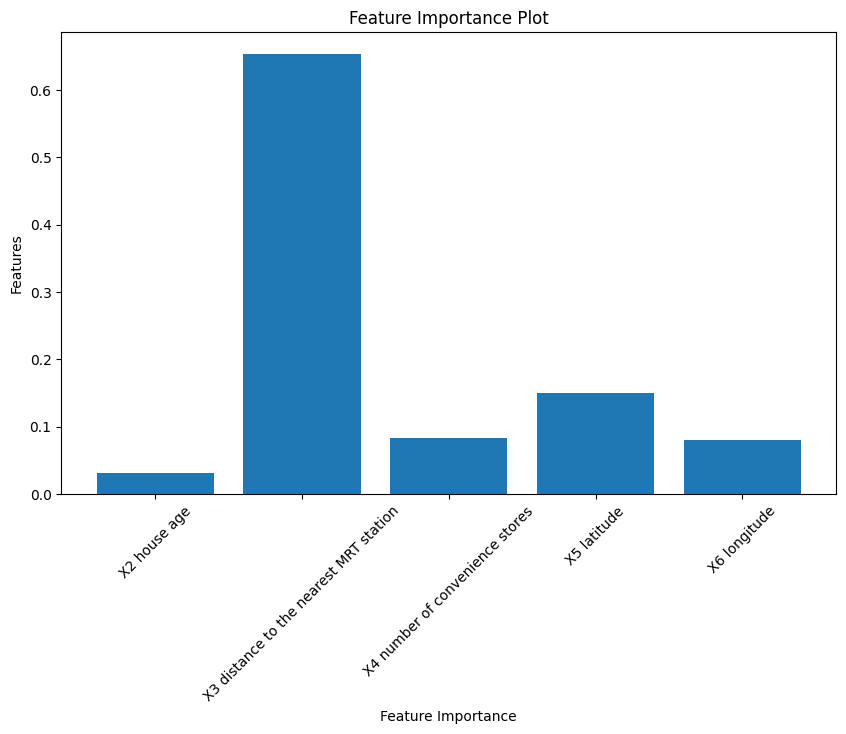

In [ ]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(x_train.columns, xgb.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.xticks(rotation=45)
plt.title('Feature Importance Plot')
plt.show()

With this bar-plot we can learn that the model declared "X3 distance to the nearest MRT station" as the most important feature.

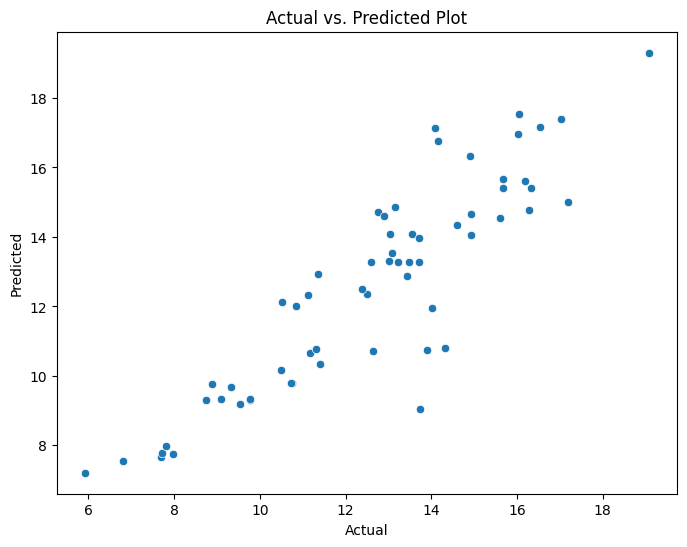

In [ ]:
# Plotting the Actual vs. Predicted plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred_val)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Plot")
plt.show()

There appears to be a positive correlation between the actual and predicted values, as the points generally follow an upward trend. This suggests that the model is capturing the underlying relationship between the features and the target variable to some extent. In addition, the points are scattered around the diagonal line (representing perfect predictions), indicating some degree of error or variation in the model's predictions. This spread seems relatively consistent across the range of values.

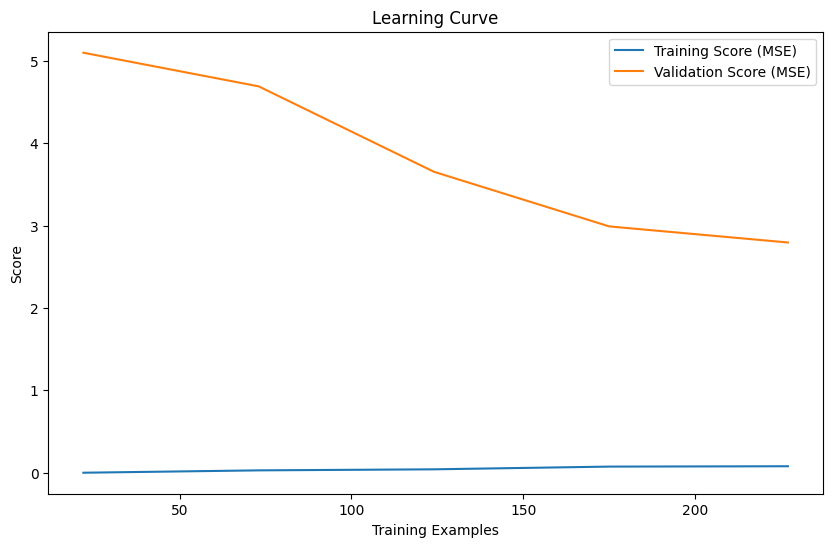

In [ ]:
# Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(xgb, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -np.mean(train_scores, axis=1), label='Training Score (MSE)')
plt.plot(train_sizes, -np.mean(val_scores, axis=1), label='Validation Score (MSE)')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

Overall, the learning curve suggests that the current model is overfitting and has high variance, indicating the need for alternative modeling approaches to improve its generalization performance.

### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initializing a RandomForestRegressor object
forest = RandomForestRegressor()

# Fitting the RandomForestRegressor model on the training data
forest.fit(x_train, y_train)

# Predicting the target variable for training and validation data
y_pred_train = forest.predict(x_train)
y_pred_val = forest.predict(x_val)

# Calculating Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for training data
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# Calculating Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for validation data
val_mse = mean_squared_error(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Printing the evaluation metrics for training data
print("Training Mean Squared Error (MSE):", train_mse)
print("Training Mean Absolute Error (MAE):", train_mae)
print("Training R-squared (R^2):", train_r2)

# Printing the evaluation metrics for validation data
print("Validation Mean Squared Error (MSE):", val_mse)
print("Validation Mean Absolute Error (MAE):", val_mae)
print("Validation R-squared (R^2):", val_r2)


Training Mean Squared Error (MSE): 0.3489056691262455
Training Mean Absolute Error (MAE): 0.4360770941054139
Training R-squared (R^2): 0.9599713300521613
Validation Mean Squared Error (MSE): 1.6634088018304243
Validation Mean Absolute Error (MAE): 0.9807141079057015
Validation R-squared (R^2): 0.7986329642327893


While the model performs very well on the training data (as indicated by low MSE, low MAE, and high R-squared), it doesn't generalize as effectively to the validation data (as indicated by higher MSE, higher MAE, and lower R-squared). This suggests that the model may be overfitting to the training data and therefore may benefit from grid search technique to improve generalization.

### **Grid Search**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

best_params = None
best_forest = None
best_mse = None
best_mae = None
best_r2 = None

# Loop through hyperparameters
for max_depth in tqdm(range(2, 15, 2)):
    for n_estimators in range(10, 200, 30):
        for min_samples_split in range(2, 10, 2):
            for min_samples_leaf in range(2, 10, 2):
                params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split}

                # Initialize random forest regressor with current hyperparameters
                forest = RandomForestRegressor(**params)

                # Fit the model on the training data
                forest.fit(x_train, y_train)

                # Predict target variable for validation data
                y_pred_val = forest.predict(x_val)

                # Calculate evaluation metrics
                mse = mean_squared_error(y_val, y_pred_val)
                mae = mean_absolute_error(y_val, y_pred_val)
                r2 = r2_score(y_val, y_pred_val)

                # Update best parameters and metrics if current model is better
                if best_mse is None or mse < best_mse:
                    best_params = params
                    best_forest = forest
                    best_mse = mse
                    best_mae = mae
                    best_r2 = r2

# Print best metrics and parameters
print(f'Best validation MSE: {best_mse}')
print(f'Best validation MAE: {best_mae}')
print(f'Best validation R^2: {best_r2}')
print(f'Best parameters: {best_params}')

# Update scores dataframe with train and validation metrics for the best random forest regressor
scores.at['forest_opt', 'train MSE'] = mean_squared_error(y_train, best_forest.predict(x_train))
scores.at['forest_opt', 'train MAE'] = mean_absolute_error(y_train, best_forest.predict(x_train))
scores.at['forest_opt', 'train R^2'] = r2_score(y_train, best_forest.predict(x_train))
scores.at['forest_opt', 'validation MSE'] = best_mse
scores.at['forest_opt', 'validation MAE'] = best_mae
scores.at['forest_opt', 'validation R^2'] = best_r2


100%|██████████| 7/7 [02:35<00:00, 22.21s/it]

Best validation MSE: 1.50572866649199
Best validation MAE: 0.9144583028764344
Best validation R^2: 0.8177212252889611
Best parameters: {'n_estimators': 70, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 6}


These results indicate that the RandomForestRegressor model with the specified hyperparameters performs reasonably well in predicting the target variable, with relatively low errors and a moderate level of explained variance.

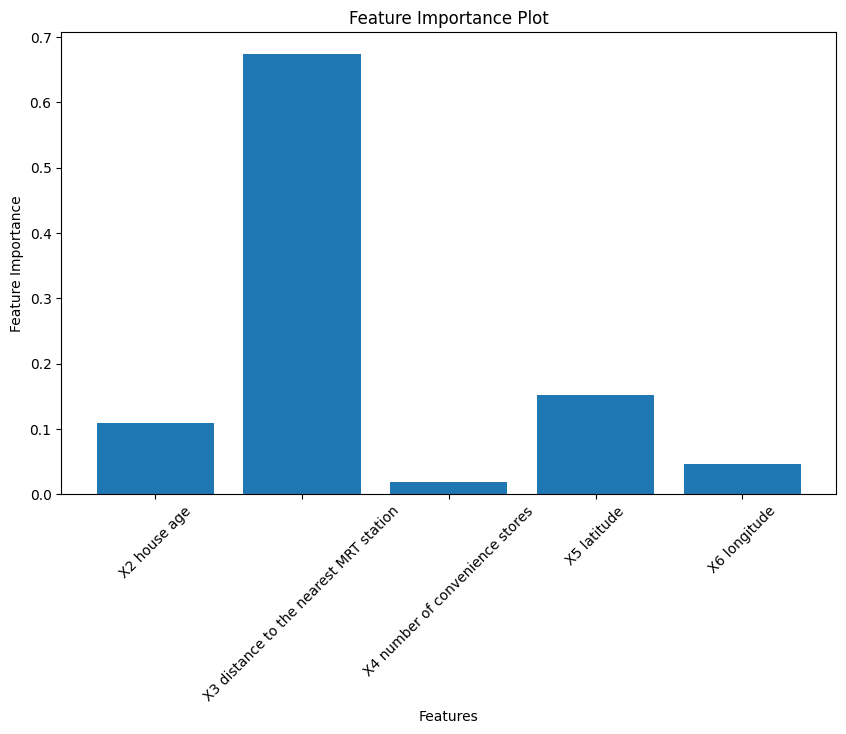

In [ ]:
# Feature Importance Plot
plt.figure(figsize=(10, 6))
plt.bar(x_train.columns, best_forest.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.xticks(rotation=45)
plt.show()

Just as the previus model, the model declared "X3 distance to the nearest MRT station" as the most important feature

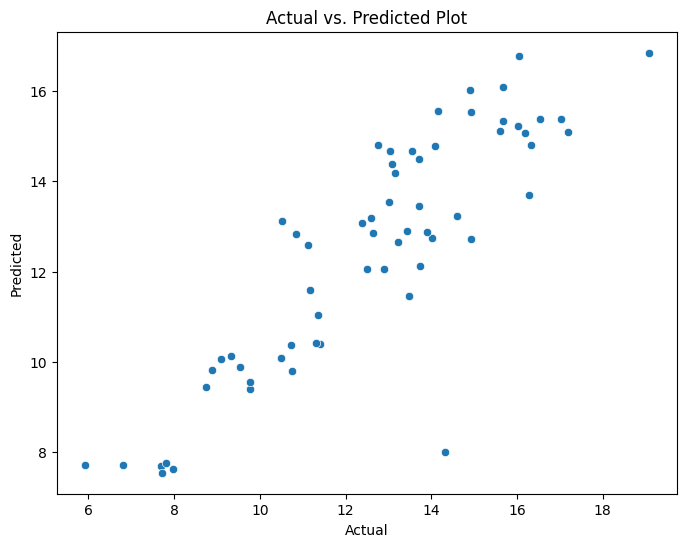

In [ ]:
# Plotting the Actual vs. Predicted plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred_val)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Plot")
plt.show()

There appears to be a positive correlation between the actual and predicted values, as the points generally follow an upward trend. This suggests that the model is capturing the underlying relationship between the features and the target variable to some extent. In addition, the points are scattered around the diagonal line, indicating some degree of error or variation in the model's predictions. This spread seems relatively consistent across the range of values.

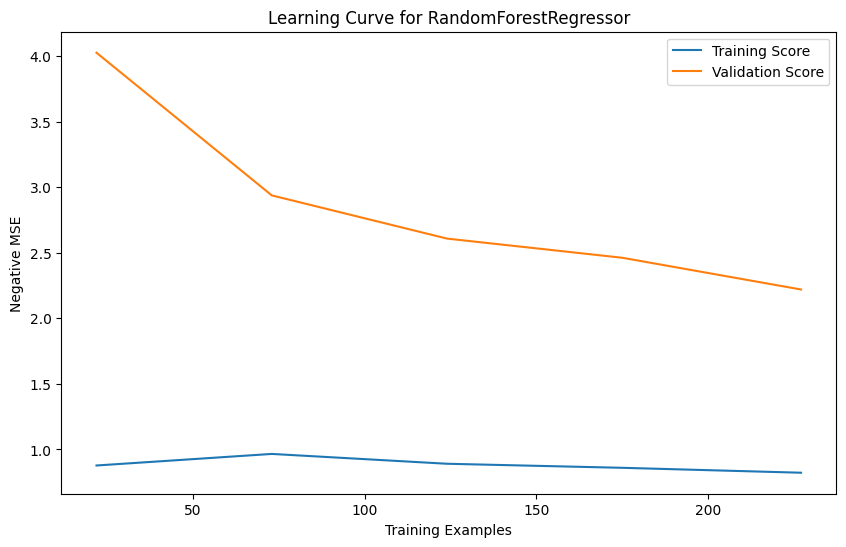

In [ ]:
# Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(best_forest, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, val_scores_mean, label='Validation Score')
plt.xlabel('Training Examples')
plt.ylabel('Negative MSE')
plt.title('Learning Curve for RandomForestRegressor')
plt.legend()
plt.show()


Overall, this learning curve is characteristic of a model that is overfitting to the training data. The RandomForestRegressor seems to be capturing noise or idiosyncrasies specific to the training set, rather than learning the true underlying patterns that would allow it to generalize well to new, unseen data.

### **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Initialize DecisionTreeRegressor
tree = DecisionTreeRegressor()

# Fit the DecisionTreeRegressor on the training data
tree.fit(x_train, y_train)

# Predictions on training and validation data
y_pred_train = tree.predict(x_train)
y_pred_val = tree.predict(x_val)

# Calculate MSE, MAE, and R^2 for training data
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# Calculate MSE, MAE, and R^2 for validation data
val_mse = mean_squared_error(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Print the evaluation metrics for training data
print("Training Mean Squared Error (MSE):", train_mse)
print("Training Mean Absolute Error (MAE):", train_mae)
print("Training R-squared (R^2):", train_r2)

# Print the evaluation metrics for validation data
print("Validation Mean Squared Error (MSE):", val_mse)
print("Validation Mean Absolute Error (MAE):", val_mae)
print("Validation R-squared (R^2):", val_r2)


Training Mean Squared Error (MSE): 0.09125251635757632
Training Mean Absolute Error (MAE): 0.09839122404715249
Training R-squared (R^2): 0.9895309329070675
Validation Mean Squared Error (MSE): 3.7451486623742123
Validation Mean Absolute Error (MAE): 1.2638920084454948
Validation R-squared (R^2): 0.5466240867428624


The model seems to perform very well on the training data, but it may be overfitting to some extent as evidenced by the higher errors and lower R-squared value on the validation set. Further regularization by using grid search, may be necessary to improve generalization performance on unseen data.

## **Grid Search**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

best_params = None
best_tree = None
best_mse = None
best_mae = None
best_r2 = None

# Perform hyperparameter tuning using grid search
for max_depth in tqdm(range(2, 15)):
    for min_samples_split in range(2, 10):
        for min_samples_leaf in range(1, 10):
            for criterion in ('friedman_mse', 'poisson', 'squared_error', 'absolute_error'):

                # Define the parameters for the DecisionTreeRegressor
                params = {'criterion': criterion, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split}

                # Initialize the DecisionTreeRegressor with the parameters
                tree = DecisionTreeRegressor(**params)

                # Fit the DecisionTreeRegressor on the training data
                tree.fit(x_train, y_train)

                # Predict target variable for validation data
                y_pred_val = tree.predict(x_val)

                # Calculate MSE, MAE, and R-squared on the validation set
                mse = mean_squared_error(y_val, y_pred_val)
                mae = mean_absolute_error(y_val, y_pred_val)
                r2 = r2_score(y_val, y_pred_val)

                # Update best MSE, MAE, R-squared, and best parameters if the current metrics are better
                if best_mse is None or mse < best_mse:
                    best_params = params
                    best_tree = tree
                    best_mse = mse
                    best_mae = mae
                    best_r2 = r2

# Print best metrics and best parameters
print(f'Best validation MSE: {best_mse}')
print(f'Best validation MAE: {best_mae}')
print(f'Best validation R^2: {best_r2}')
print(f'Best parameters: {best_params}')

# Update scores dataframe with train and validation metrics for the best decision tree regressor
scores.at['tree_opt', 'train MSE'] = mean_squared_error(y_train, best_tree.predict(x_train))
scores.at['tree_opt', 'train MAE'] =  mean_absolute_error(y_train, best_tree.predict(x_train))
scores.at['tree_opt', 'train R^2'] =  r2_score(y_train, best_tree.predict(x_train))
scores.at['tree_opt', 'validation MSE'] = best_mse
scores.at['tree_opt', 'validation MAE'] = best_mae
scores.at['tree_opt', 'validation R^2'] = best_r2


100%|██████████| 13/13 [00:24<00:00,  1.85s/it]

Best validation MSE: 1.6334138386630686
Best validation MAE: 0.9712050306001484
Best validation R^2: 0.8022640600970835
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3}


After the grid search, these metrics indicate that the model performs reasonably well, with relatively low errors and a moderate level of explained variance.

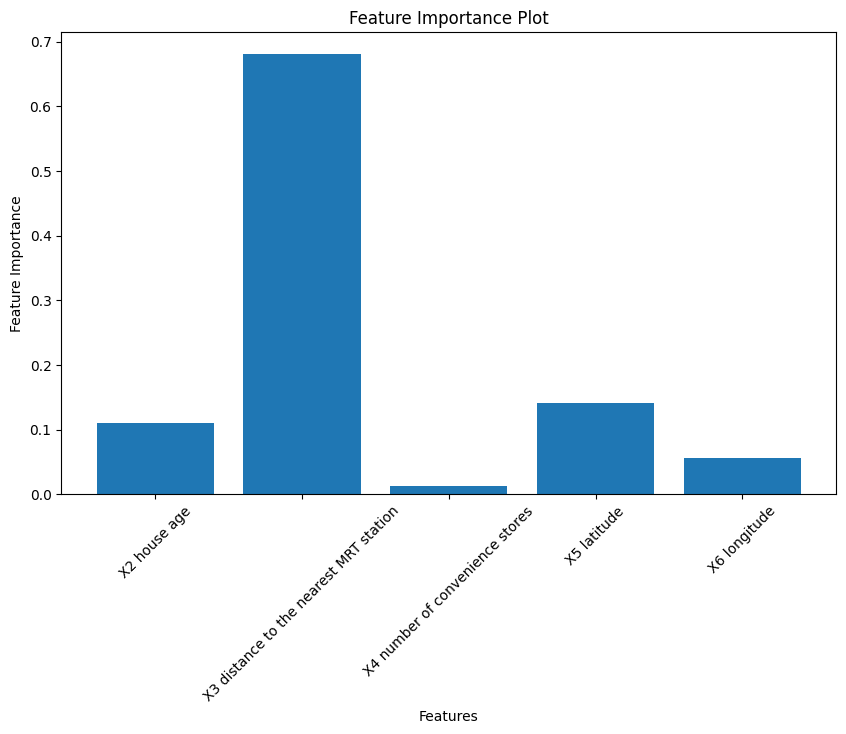

In [ ]:
# Feature Importance Plot
plt.figure(figsize=(10, 6))
plt.bar(x_train.columns, best_tree.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.xticks(rotation=45)
plt.show()

Just as the previus model, the model declared "X3 distance to the nearest MRT station" as the most important feature

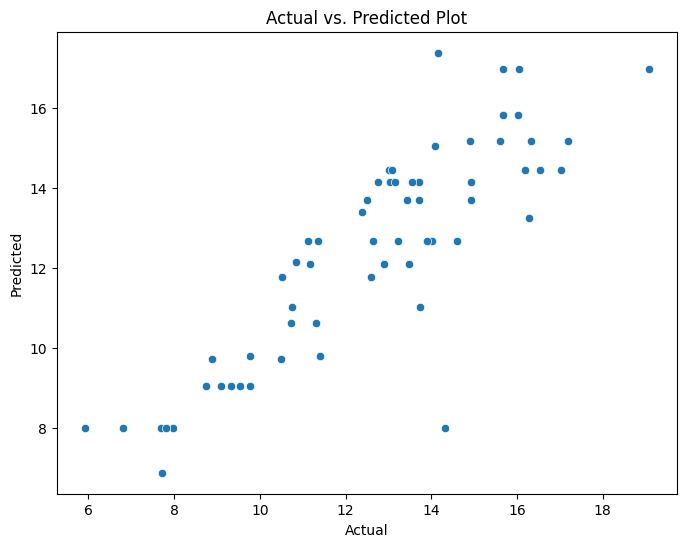

In [ ]:
# Plotting the Actual vs. Predicted plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred_val)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Plot")
plt.show()

The points are scattered around the diagonal line, indicating some discrepancies between the actual and predicted values.
there is a noticeable spread of points away from the diagonal, suggesting the model's predictions deviate from the actual values to some degree.

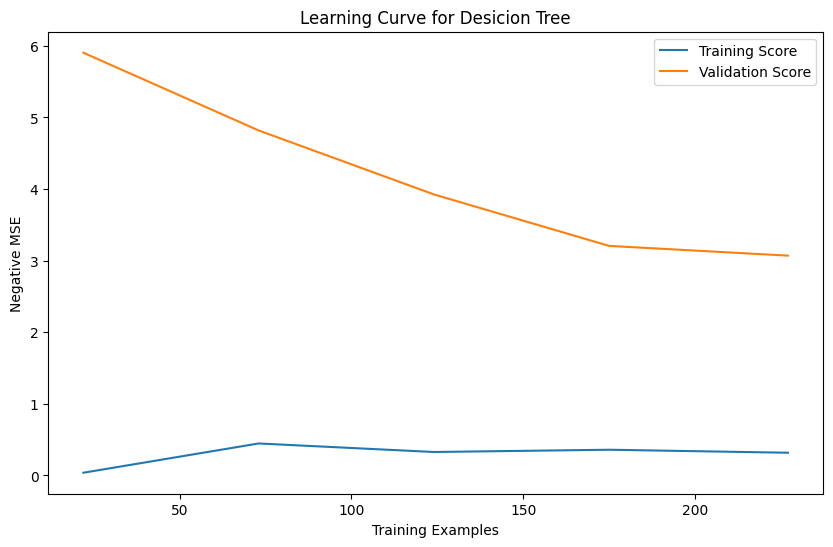

In [ ]:
# Plot a learning curve
train_sizes, train_scores, val_scores = learning_curve(best_tree, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, val_scores_mean, label='Validation Score')
plt.xlabel('Training Examples')
plt.ylabel('Negative MSE')
plt.title('Learning Curve for Desicion Tree')
plt.legend()
plt.show()


The learning curve suggests that the desicion tree model is prone to overfitting on this particular dataset. While it can fit the training data very well, its ability to generalize to new, unseen data is limited.

### **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize KNeighborsRegressor with defult 5 neighbors
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data
knn.fit(x_train, y_train)

# Make predictions on the training and validation sets
y_pred_train = knn.predict(x_train)
y_pred_val = knn.predict(x_val)

# Calculate Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for training data
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# Calculate Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for validation data
val_mse = mean_squared_error(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Print the evaluation metrics for training data
print("Training Mean Squared Error (MSE):", train_mse)
print("Training Mean Absolute Error (MAE):", train_mae)
print("Training R-squared (R^2):", train_r2)

# Print the evaluation metrics for validation data
print("Validation Mean Squared Error (MSE):", val_mse)
print("Validation Mean Absolute Error (MAE):", val_mae)
print("Validation R-squared (R^2):", val_r2)


Training Mean Squared Error (MSE): 2.001832377771317
Training Mean Absolute Error (MAE): 1.0349505170926416
Training R-squared (R^2): 0.7703371007373588
Validation Mean Squared Error (MSE): 2.735041332662174
Validation Mean Absolute Error (MAE): 1.2669451762171389
Validation R-squared (R^2): 0.6689045018561051


The model seems to perform well on the training set, as evidenced by relatively low MSE and MAE values and a high R-squared value. However, there seems to be some degree of overfitting, as indicated by the higher MSE and MAE values and lower R-squared value on the validation set compared to the training set. Further optimization by using grid search may be necessary to improve the model's performance on unseen data.

### **Grid Search**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

best_params = None
best_knn = None
best_mse = None
best_mae = None
best_r2 = None

# Perform hyperparameter tuning using grid search
for n_neighbors in tqdm([3, 5, 7, 9]):
    for weights in ['uniform', 'distance']:
        for algorithm in ['auto', 'ball_tree', 'kd_tree', 'brute']:
            for leaf_size in [10, 20, 30, 40]:
                for p in [1, 2]:
                    # Define the parameters for the KNeighborsRegressor
                    params = {'n_neighbors': n_neighbors, 'weights': weights, 'algorithm': algorithm, 'leaf_size': leaf_size, 'p': p}

                    # Initialize the KNeighborsRegressor with the parameters
                    knn = KNeighborsRegressor(**params)

                    # Fit the KNeighborsRegressor on the training data
                    knn.fit(x_train, y_train)

                    # Predict target variable for validation data
                    y_pred_val = knn.predict(x_val)

                    # Calculate MSE, MAE, and R-squared on the validation set
                    mse = mean_squared_error(y_val, y_pred_val)
                    mae = mean_absolute_error(y_val, y_pred_val)
                    r2 = r2_score(y_val, y_pred_val)

                    # Update best MSE, MAE, R-squared, and best parameters if the current metrics are better
                    if best_mse is None or mse < best_mse:
                        best_params = params
                        best_knn = knn
                        best_mse = mse
                        best_mae = mae
                        best_r2 = r2

# Print best metrics and best parameters
print(f'Best validation MSE: {best_mse}')
print(f'Best validation MAE: {best_mae}')
print(f'Best validation R^2: {best_r2}')
print(f'Best parameters: {best_params}')

# Update scores dataframe with train and validation metrics for the best KNeighborsRegressor
scores.at['knn_opt', 'train MSE'] = mean_squared_error(y_train, best_knn.predict(x_train))
scores.at['knn_opt', 'train MAE'] = mean_absolute_error(y_train, best_knn.predict(x_train))
scores.at['knn_opt', 'train R^2'] = r2_score(y_train, best_knn.predict(x_train))
scores.at['knn_opt', 'validation MSE'] = best_mse
scores.at['knn_opt', 'validation MAE'] = best_mae
scores.at['knn_opt', 'validation R^2'] = best_r2


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Best validation MSE: 1.996959230045019
Best validation MAE: 1.09115598976453
Best validation R^2: 0.7582543988828002
Best parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 10, 'p': 2}


After fitting the model again with the best parameters, we can see our model's preformance slightly improved.

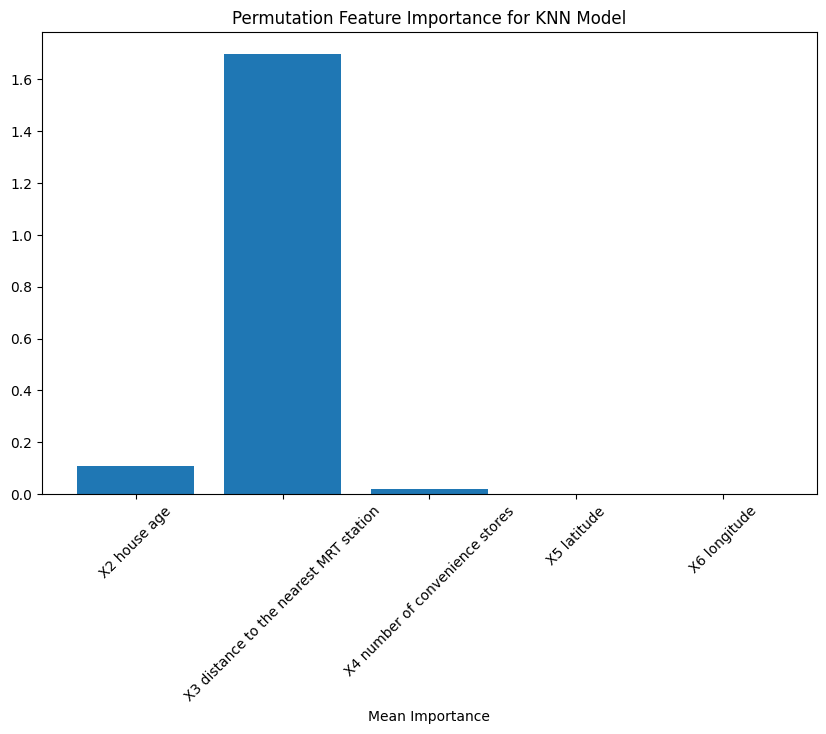

In [ ]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance
result = permutation_importance(best_knn, x_val, y_val, n_repeats=10, random_state=42)

# Sort feature importance scores
sorted_idx = result.importances_mean.argsort()

# Plot permutation feature importance
plt.figure(figsize=(10, 6))
plt.bar(x_train.columns, result.importances_mean)
plt.xlabel('Mean Importance')
plt.xticks(rotation=45)
plt.title('Permutation Feature Importance for KNN Model')
plt.show()

The model identified "X3 distance to the nearest MRT station" as the most influential feature. However, after evaluating the model's current performance, it appears that the predictions are no longer significantly affected by other features.

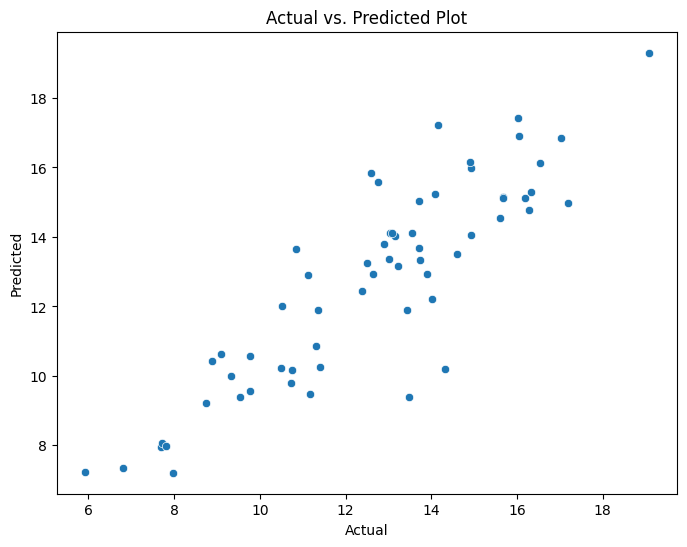

In [ ]:
# Plotting the Actual vs. Predicted plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred_val)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Plot")
plt.show()

The points are scattered around a diagonal line, indicating some degree of error or variation in the model's predictions. This spread seems relatively inconsistent across the range of values.

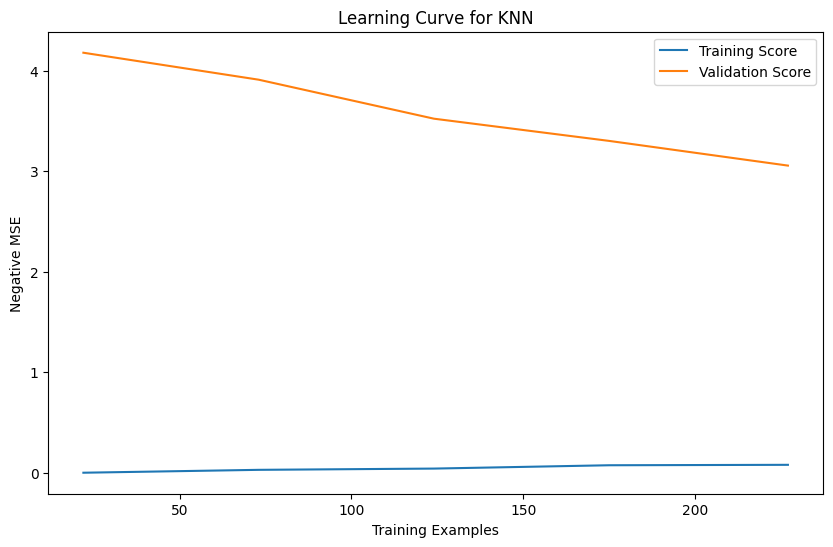

In [ ]:
# Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(best_knn, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, val_scores_mean, label='Validation Score')
plt.xlabel('Training Examples')
plt.ylabel('Negative MSE')
plt.title('Learning Curve for KNN')
plt.legend()
plt.show()


The learning curve in this graph suggests that the KNN model may be slightly overfitting the training data.

# **Best Model**

In [ ]:
scores

,train MSE,validation MSE,train MAE,validation MAE,train R^2,validation R^2
linear_opt,3.204771,2.893046,1.308563,1.172774,0.632328,0.649777
xgb_opt,0.091255,1.841754,0.099271,0.980974,0.989531,0.777043
forest_opt,0.827077,1.505729,0.642177,0.914458,0.905113,0.817721
tree_opt,0.408305,1.633414,0.394571,0.971205,0.953157,0.802264
knn_opt,0.091253,1.996959,0.098394,1.091156,0.989531,0.758254


In our assessment, the decision tree and random forest models stand out for their superior performance on both the training and validation sets. However, when compared to the other models, it's apparent that there is a general issue of overfitting across all of models.

# **Testing the Random Forest model**

In [ ]:
# Predict target variable for test data using the best random forest regressor
y_pred_test = best_forest.predict(x_test)

# Calculate evaluation metrics on test set
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Print evaluation metrics on test set
print("test MSE:", test_mse)
print("test MAE:", test_mae)
print("test R^2:", test_r2)

test MSE: 1.9686433527626592
test MAE: 1.021480256446759
test R^2: 0.7857271002314624


In [ ]:
# Predict target variable for test data using the best decision tree regressor
y_pred_test = best_tree.predict(x_test)

# Calculate evaluation metrics on test set
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Print evaluation metrics on test set
print("test MSE:", test_mse)
print("test MAE:", test_mae)
print("test R^2:", test_r2)

test MSE: 3.144562970586944
test MAE: 1.2480981209565154
test R^2: 0.6577365700766095


After evaluating the performance of the trained models with optimal hyperparameters, it appears that the random forest model outperforms the decision tree model.